# Community similarities

This notebook focuses on detecting communities within the FriendFeed social network. We'll use the preprocessed datasets to build a graph and analyze community structures.

In [37]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from networkx.algorithms.centrality import degree_centrality, betweenness_centrality

### 1. Load celaned input data

In [7]:
%%time
# Load preprocessed data
users = pd.read_parquet('processed_data/users_cleaned.parquet')
subs = pd.read_parquet('processed_data/subs_cleaned.parquet')
following = pd.read_parquet('processed_data/following_cleaned.parquet')
comments = pd.read_parquet('processed_data/comments_cleaned.parquet')
likes = pd.read_parquet('processed_data/likes_cleaned.parquet')
entries = pd.read_parquet('processed_data/entries_cleaned.parquet')

CPU times: user 30.4 s, sys: 18.6 s, total: 49 s
Wall time: 33.3 s


In [8]:
print(f'users columns: {list(users.columns)}')
print(f'subs columns: {list(subs.columns)}')
print(f'following columns: {list(following.columns)}')
print(f'comments columns: {list(comments.columns)}')
print(f'likes columns: {list(likes.columns)}')
print(f'entries columns: {list(entries.columns)}')

users columns: ['ID', 'Type', 'Name', 'Description']
subs columns: ['FollowerID', 'FollowedID']
following columns: ['FollowerID', 'FollowedID', 'Timestamp']
comments columns: ['PostID', 'EntryID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text']
likes columns: ['userID', 'PostID', 'Timestamp']
entries columns: ['PostID', 'PostedBy', 'SourceURL', 'Timestamp', 'Text']


## 2. load the network from files

In [2]:
graph_3 = nx.read_gexf("graph/subgraph_3.gexf")
num_nodes = graph_3.number_of_nodes()
num_edges = graph_3.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 12776
Number of Edges: 299677


In [3]:
graph_20 = nx.read_gexf("graph/subgraph_20.gexf")
num_nodes = graph_20.number_of_nodes()
num_edges = graph_20.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2442
Number of Edges: 12395


In [4]:
graph_11 = nx.read_gexf("graph/subgraph_11.gexf")
num_nodes = graph_11.number_of_nodes()
num_edges = graph_11.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2240
Number of Edges: 51294


In [5]:
graph_52 = nx.read_gexf("graph/subgraph_52.gexf")
num_nodes = graph_52.number_of_nodes()
num_edges = graph_52.number_of_edges()

print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)

Number of Nodes: 2138
Number of Edges: 25151


### 3. Analyze graphs

In [29]:
def print_head_data_for_graph(graph_nbr):
    node_attributes = {node: data for node, data in graph_nbr.nodes(data=True)}
    print(len(node_attributes))
    for key, value in list(node_attributes.items())[:5]:
        print(key, value)
    
    print("-----------------------------")
    edge_attributes = {(u, v): data for u, v, data in graph_nbr.edges(data=True)}
    print(len(edge_attributes))
    for (u, v), data in list(edge_attributes.items())[:5]:
        print(f"Edge: ({u}, {v}), Attributes: {data}")

In [31]:
def find_and_cound_edge_types(graph_nbr):
    relationship_counter = Counter()
    # Loop through the edges in graph_52 and access the 'relationship' attribute
    for _, _, data in graph_nbr.edges(data=True):
        if 'relationship' in data:
            relationship_counter[data['relationship']] += 1

    print(relationship_counter)

In [35]:
def find_distinct_node_names_with_specific_edge_type(graph_nbr, head=5):
    # Create a defaultdict to store nodes for each relationship type
    relationship_nodes = defaultdict(set)
    
    # Loop through the edges in the graph and categorize the nodes based on the 'relationship' attribute
    for u, v, data in graph_nbr.edges(data=True):
        if 'relationship' in data:
            relationship_type = data['relationship']
            # Add both nodes to the set for that relationship type
            relationship_nodes[relationship_type].add(u)
            relationship_nodes[relationship_type].add(v)
    
    for relationship, nodes in relationship_nodes.items():
        print(f"Relationship: '{relationship}' has {len(nodes)} number of distinct nodes!")
        print(f"* Nodes: {list(nodes)[:head]}...\n")  # Print only the first 3 nodes for brevity
    return relationship_nodes

In [43]:
def detect_Influencers_in_graph(graph_52, number=5):
    """
    - Degree_centrality measures how many edges (connections) a node has to other nodes. 
        Nodes with high degree centrality are those that are directly connected to many other nodes. 
        They act as "hubs" in the network.
    - Betweenness_centrality measures how often a node lies on the shortest path between 
        two other nodes in the network.
        Nodes with high betweenness centrality act as bridges between different parts of the network and play a key role in facilitating communication or information flow
    """
    degree_cent = degree_centrality(graph_52)
    betweenness_cent = betweenness_centrality(graph_52)
    
    # Find top 5 central nodes based on degree centrality
    central_nodes_by_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:number]
    print("Top 5 central nodes by degree centrality with scores:")
    for node, score in central_nodes_by_degree:
        print(f"Node: {node}, Degree Centrality: {score}")
    
    # Find top 5 central nodes based on betweenness centrality
    central_nodes_by_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:number]
    print("\nTop 5 central nodes by betweenness centrality with scores:")
    for node, score in central_nodes_by_betweenness:
        print(f"Node: {node}, Betweenness Centrality: {score}")

    return central_nodes_by_degree, central_nodes_by_betweenness

In [71]:
def detect_Influencers_in_graph(graph_nbr, central_nodes_by_degree, central_nodes_by_betweenness, spread_factor=2):
    """
    Detect and visualize influencers in the graph based on degree centrality (node size) 
    and betweenness centrality (node color).
    """
    # Get list of top betweenness nodes for coloring
    top_betweenness_nodes = {node for node, _ in central_nodes_by_betweenness}
    
    # Create node sizes based on degree centrality
    node_sizes = [degree_cent[node] * 800 for node in graph_nbr.nodes()]
    
    # Create node colors: red for top betweenness nodes, blue for others
    node_colors = ['red' if node in top_betweenness_nodes else 'blue' for node in graph_nbr.nodes()]
    
    # Draw the graph with node sizes and colors
    plt.figure(figsize=(10, 10))
    
    # pos = nx.spring_layout(graph_nbr)  # Layout for positioning the nodes
    pos = nx.spring_layout(graph_nbr, k=spread_factor / np.sqrt(graph_nbr.number_of_nodes()))  # Adjust spread_factor
    nx.draw_networkx_nodes(graph_nbr, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)
    nx.draw_networkx_edges(graph_nbr, pos, alpha=0.01)
    # nx.draw_networkx_labels(graph_nbr, pos, font_size=8)
    
    plt.title("Graph Visualization with Centrality Measures")
    plt.show()

    return central_nodes_by_degree, central_nodes_by_betweenness


#### 4. Analyze graph_52

In [30]:
print_head_data_for_graph(graph_52)

2138
johanlipeckiwestin {'community': 52, 'label': 'johanlipeckiwestin'}
vesakotilainen {'community': 52, 'label': 'vesakotilainen'}
smyrnakyrkan {'community': 52, 'label': 'smyrnakyrkan'}
chrisaliaga {'community': 52, 'label': 'chrisaliaga'}
haflidason {'community': 52, 'label': 'haflidason'}
-----------------------------
25151
Edge: (johanlipeckiwestin, jonathanstara), Attributes: {'relationship': 'subs', 'id': '0'}
Edge: (johanlipeckiwestin, doktorspinn), Attributes: {'relationship': 'subs', 'id': '1'}
Edge: (vesakotilainen, tieke), Attributes: {'relationship': 'subs', 'id': '2'}
Edge: (smyrnakyrkan, joegus), Attributes: {'relationship': 'subs', 'id': '3'}
Edge: (smyrnakyrkan, lydiamorling), Attributes: {'relationship': 'subs', 'id': '4'}


In [32]:
find_and_cound_edge_types(graph_52)

Counter({'subs': 18335, 'following': 6799, 'comment': 10, 'like': 7})


In [36]:
relationship_nodes = find_distinct_node_names_with_specific_edge_type(graph_52, 4)

Relationship: 'subs' has 2137 number of distinct nodes!
* Nodes: ['tommyjeppsson', 'stasha', 'juspetle', 'janmagnusson']...

Relationship: 'following' has 1146 number of distinct nodes!
* Nodes: ['kijuaunweatherspoon', 'runeby', 'tommyjeppsson', 'kimelman']...

Relationship: 'comment' has 16 number of distinct nodes!
* Nodes: ['ericceder', 'chadie', 'mymlan', 'kalstrom']...

Relationship: 'like' has 11 number of distinct nodes!
* Nodes: ['karinnilssonmalmn', 'hammarstrand', 'jonasjonsson', 'doktorspinn']...



In [46]:
detect_Influencers_in_graph(graph_52, 3);

Top 5 central nodes by degree centrality with scores:
Node: jardenberg, Degree Centrality: 0.3406644829199813
Node: mymlan, Degree Centrality: 0.270004679457183
Node: jonasl, Degree Centrality: 0.22882545624707534

Top 5 central nodes by betweenness centrality with scores:
Node: jardenberg, Betweenness Centrality: 0.09270793816763509
Node: wheelforce, Betweenness Centrality: 0.08816202331683125
Node: oskariuotinen, Betweenness Centrality: 0.08136893335786771


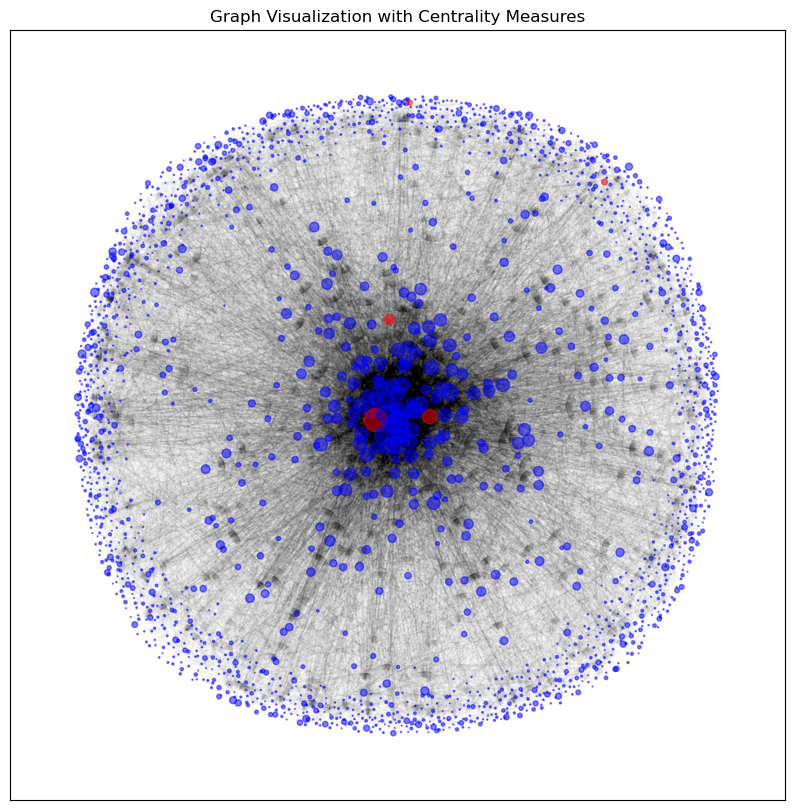

CPU times: user 1min 33s, sys: 1.84 s, total: 1min 34s
Wall time: 1min 15s


In [72]:
%%time
detect_Influencers_in_graph(graph_52, central_nodes_by_degree, central_nodes_by_betweenness, spread_factor=40);